# Assignment 3
### Question 2 - CNN model

In this part of the assignment, the same classification problem will be resolved using CNN architecture. The modelling started with a simple layer and later more layers were added to improvise the accuracy. The code below walks you through all the steps that led to the final layer structuring.

The dataset is fashion MNIST with 786 columns and 60,000 observations. Due to the large size of data and incompatible system configuration, the implementation was moved to google colabs. This dataset is the representation of five different kinds of fashion items. Each row represents one fashion item and every column of the row stores the pixel value used to generate the image of the fashion item. Based on these values, we have to classify the data into 5 distinct categories.
 
The different methods used for implementation and the reasons why, have been discussed along with the code snippets, combining question 1 and 2 asked in the assignment.

Also, some sections had to interrupt when executing the second time due to long hours they were taking for implementation.

In [0]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import keras
import keras.utils
from keras.models import Sequential
from keras import utils as np_utils
from keras.models import Model
from keras.layers import Dense, Input
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization, AveragePooling2D
from keras import backend as k
import time as time
from keras import optimizers
from keras import regularizers
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
from keras.constraints import max_norm
import os


The implementation started with loading the train and test dataset. The test dataset had 10,000 observations on which the accuracy of the model was calculated. The train dataset was then split into train and validation set(10% of the total data), to check the validity of the model before running it on the test data. The data was transformed into a 28X28 matrix to generate the images for better visual understanding using imshow()

In [23]:
data_train_orig = pd.read_csv('train.csv')

y_train_0 = data_train_orig['Label']

X_train_0 = data_train_orig.drop("Id", axis = 1)   # Dropping the Id column as it seems to be redundant
X_train_1 = X_train_0.drop("Label", axis = 1)

seed = 42

X_train, X_val, y_train, y_val = train_test_split(X_train_1, y_train_0, random_state = seed, test_size = 0.1)                                       # Dropping the column of target labels to retain only the feature values

data_test_orig = pd.read_csv('testX.csv')

X_test = data_test_orig.drop("Id", axis = 1)   

print("Shape of Training Features:", X_train.shape)
print("Shape of Validate Features:", X_val.shape)
print("Shape of Training labels:", y_train.shape)
print("Shape of Validation labels:", y_val.shape)
print("Shape of Testing Features:", X_test.shape)
# print("Shape of Training Features:", y_test.shape) 

Shape of Training Features: (54000, 784)
Shape of Validate Features: (6000, 784)
Shape of Training labels: (54000,)
Shape of Validation labels: (6000,)
Shape of Testing Features: (10000, 784)


The total number of unique classes were checked 

In [24]:
# Find the unique numbers from the train labels
classes = np.unique(y_train)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  5
Output classes :  [0 1 2 3 4]


They are reshaped in the shape the model expects them to be in. 

In [0]:
# Image Data format
# Grayscale images are loaded as a 2-D array. Before they can be used for modeling, an explicit channel dimension to the image in necessary. 
# This does not add new data; instead, it changes the array data structure to have an additional third axis with one dimension to hold the grayscale pixel values.

img_rows, img_cols = 28,28

# Keras have default as channel last
X_train = X_train.values.reshape(X_train.shape[0], img_rows, img_cols, 1)  
X_val = X_val.values.reshape(X_val.shape[0], img_rows, img_cols, 1) 
X_test = X_test.values.reshape(X_test.shape[0], img_rows, img_cols, 1)         
X_inp = (img_rows, img_cols, 1) 

In [7]:
print('Training data shape : ', X_val.shape, y_train.shape)

Training data shape :  (6000, 28, 28, 1) (54000,)


Since the image pixel values ranges between 0 and 255, the data is normalized by dividing each pixel by the maximum of the range i.e. 255.

In [0]:
# Normalizing data
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_val /= 255
X_test /= 255

By doing this step, we create 5 columns corresponding to each of the 5 categories

In [0]:
# 5 Target classes: 0 - 4
# keras.utils.to_categorical will create 5 columns

y_train = keras.utils.to_categorical(y_train) 
y_val = keras.utils.to_categorical(y_val)
#y_test = keras.utils.to_categorical(y_test)

The following variables were set after testing them with different combinations. The batch_size was tested on smaller sizes but that resulted in the model taking a lot of time to compute the results. Therefore, 512 was chosen as the final size.

Epochs were also tested on 20, 50, 100 and 200. It was observed that the increase in accuracy between 100 and 200 was very slow compared to that of 0-100. Therefore, the number of epochs were set as 200 because they did not increase beyond that point. 


In [0]:
batch_size = 512
epochs = 200
num_classes = 5

Convolution is nothing but weighted sum of pixel values of the image. As we define the size of the sliding window, the convolution calculates the weight over those values under consideration. As the window slides, it convolves the window with the images to generate a new value for the image pixel. Once the values are generated, max pooling is executed. Max pooling is used for reducing the dimensionality of the image. What is does is it picks up the maximum values from the set of values within the window and allocates it as the new value of the reduced dimension. This window keeps on sliding till a new layer with reduced dimensionality is produced. But the layers produced are 3D in nature and for a fully connected network, we need a vector of values. To do that flatten() is used which converts it into a vector. Lastly, Dense layer is a fully connected network just like an ANN. Dropout layers are also added to drop the neurons in the layer i.e. if p=0.5, then 50% of the neurons are dropped. Batch Normalization can also be done. It is another way to regularizer the data.

# Hyperparameter tuning 
Hyerparameter tuning is another part that need to be considered while convolving the layers. These are usually generated by testing and trying different values. For example, what kindly of padding shall be done(same is preserved as it borders the outline with same values as the previous layer), what kind of activation function shall be chosen(linear or relu). I tried with linear and later adding a layer of LeakyRelu layer but that hampered the performance of the model, therefore activation function was directly set to relu. Different combinations with dropout were tested as well but setting it equal to 0.5 yielded best results.

Also, the activation function is set to relu as it resolves the problem of vanishing gradient. Thats why, when the activation was set to linear, the accuracy was dropped because of vanishing gradient.

kernel size is set to 3X3 for Conv2D as this the smallest window on which the model performs best convolution. Even the number of filters are chosen to be small so that the model does not overfit the training set. The initial value is small but as the parameters increase, the number of filters change accordingly.

For max_pooling, the window size is 2X2 so that no information is lost as well as it is made sure that the edges are sharpened. For Dense, a fully connected network is designed, therfore the transition from given nodes to the output nodes shall be smooth and it shall be made sure that no information is lost on the way. Adding too many layers can also lead to overfitting the train data resulting in lower accuracy.

Usually the CNN initial layers work as edge detector and as we increase the number of layers more features start becoming prominent. Max pooling after CNN makes edges noticeable. Also dense layers help in retaining the properties of the data, therefore more the layers, more hidden features can be fetched.

In [0]:
# Model 1
# fashion_model = Sequential()
# fashion_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(28,28,1)))
# fashion_model.add(LeakyReLU(alpha=0.1))
# fashion_model.add(MaxPooling2D((2, 2),padding='same'))
# fashion_model.add(Flatten())
# fashion_model.add(Dense(128, activation='linear'))
# fashion_model.add(LeakyReLU(alpha=0.1))           
# fashion_model.add(Dropout(0.5))
# fashion_model.add(Dense(num_classes, activation='softmax'))

# 72% accuracy on test data, training - 85%, val - 76%

I tried with linear and later adding a layer of LeakyRelu layer but that hampered the performance of the model, therefore activation function was directly set to relu.

In [0]:
# Model 2
# fashion_model = Sequential()
# fashion_model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding='same',input_shape=(28,28,1)))
# fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
# fashion_model.add(Dropout(0.5))
# fashion_model.add(Flatten())
# fashion_model.add(Dense(128, activation='relu'))
# fashion_model.add(Dense(num_classes, activation='softmax'))

# 82.4% accuracy on test data, training - 89%, val - 84%

Increasing the number of convolution layer improvised the accuracy on validation set

In [0]:
# Model 3
# fashion_model = Sequential()
# fashion_model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding='same',input_shape=(28,28,1)))
# fashion_model.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
# fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
# fashion_model.add(Dropout(0.5))
# fashion_model.add(Flatten())
# fashion_model.add(Dense(128, activation='relu'))
# fashion_model.add(Dense(num_classes, activation='softmax'))

# 84.6% accuracy on test data, training - 92%, val - 86%

Adding another segment of convolution layer and max pooling with dropout increased the performance but time taken was also increased, therefore from the second segment one convolution layer was removed, leaving only one in that segment. It was observed that the change in accuarcy was marginal but the time was improvised be a great extent.

In [0]:
# Model 4
# fashion_model = Sequential()
# fashion_model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding='same',input_shape=(28,28,1)))
# fashion_model.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
# fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
# fashion_model.add(Dropout(0.5))
# fashion_model.add(Conv2D(128, (3, 3), activation='relu',padding='same'))           
# fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
# fashion_model.add(Dropout(0.5))
# fashion_model.add(Flatten())
# fashion_model.add(Dense(128, activation='relu'))
# fashion_model.add(Dense(num_classes, activation='softmax'))
#86.7% accuracy on test data, training - 95%, val - 87%

For regularizing the data, Batch normalization was added. But it was observed that this led to decrease in the validation accuracy. 

In [0]:
# Model 5
# fashion_model = Sequential()
# fashion_model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding='same',input_shape=(28,28,1)))
# fashion_model.add(BatchNormalization())
# fashion_model.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
# fashion_model.add(BatchNormalization())
# fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
# fashion_model.add(Dropout(0.5))
# fashion_model.add(Conv2D(128, (3, 3), activation='relu',padding='same'))  
# fashion_model.add(BatchNormalization())          
# fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
# fashion_model.add(Dropout(0.5))
# fashion_model.add(Flatten())
# fashion_model.add(Dense(128, activation='relu'))
# fashion_model.add(BatchNormalization())
# fashion_model.add(Dense(num_classes, activation='softmax'))
#80.3% accuracy on test data, training - 89%, val - 82%

To improvise on the model, Batch Normalization was removed from the dense layers as it regularized the data(features) that were extracted from the fully connected layer. This led to loss of information, hence it was removed.

In [0]:
# model 6
# fashion_model = Sequential()
# fashion_model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding='same',input_shape=(28,28,1)))
# fashion_model.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
# fashion_model.add(BatchNormalization())
# fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
# fashion_model.add(Dropout(0.5))
# fashion_model.add(Conv2D(128, (3, 3), activation='relu',padding='same'))  
# fashion_model.add(BatchNormalization())          
# fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
# fashion_model.add(Dropout(0.5))
# fashion_model.add(Flatten())
# fashion_model.add(Dense(128, activation='relu'))
# fashion_model.add(Dense(num_classes, activation='softmax'))
#88% accuracy on test data, training - 97%, val - 90%

In [0]:
# model 7
# import keras
# from keras.models import Sequential,Input,Model
# from keras.layers import Dense, Dropout, Flatten
# from keras.layers import Conv2D, MaxPooling2D
# from keras.layers.normalization import BatchNormalization
# fashion_model = Sequential()
# fashion_model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding='same',input_shape=(28,28,1)))
# fashion_model.add(BatchNormalization())
# fashion_model.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
# fashion_model.add(BatchNormalization())
# fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
# fashion_model.add(Dropout(0.5))
# fashion_model.add(Conv2D(128, (3, 3), activation='relu',padding='same'))  
# fashion_model.add(BatchNormalization())          
# fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
# fashion_model.add(Dropout(0.5))
# fashion_model.add(Flatten())
# fashion_model.add(Dense(128, activation='relu'))
# fashion_model.add(Dense(64, activation='relu'))
# fashion_model.add(Dense(num_classes, activation='softmax'))
# 90.7% accuracy on test data, training - 97%, val - 91%

Finally, adding another Dense layer led to the generation of best accuracy of the model. The reported accuracy of the model was 90.72% 

In [0]:
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
fashion_model = Sequential()
fashion_model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding='same',input_shape=(28,28,1)))
fashion_model.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
fashion_model.add(BatchNormalization())
fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
fashion_model.add(Dropout(0.5))
fashion_model.add(Conv2D(128, (3, 3), activation='relu',padding='same'))  
fashion_model.add(BatchNormalization())          
fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
fashion_model.add(Dropout(0.5))
fashion_model.add(Flatten())
fashion_model.add(Dense(128, activation='relu'))
fashion_model.add(Dense(64, activation='relu'))
fashion_model.add(Dense(num_classes, activation='softmax'))

This was another architecture that was tested but the results were not upto satisfaction. Adding additional Conv2d layer results in overfitting because of which the accuracy is affected.

In [0]:
# fashion_model = Sequential()
# fashion_model.add(Conv2D(32, (3, 3),activation='relu', padding="same",input_shape=(28,28,1)))
# fashion_model.add(BatchNormalization())
# fashion_model.add(Conv2D(32, (3, 3),activation='relu', padding="same"))
# fashion_model.add(BatchNormalization())
# fashion_model.add(MaxPooling2D(pool_size=(2, 2)))
# fashion_model.add(Dropout(0.5))
# # second CONV => RELU => CONV => RELU => POOL layer set
# fashion_model.add(Conv2D(64, (3, 3),activation='relu', padding="same"))
# fashion_model.add(BatchNormalization(axis=-1))
# fashion_model.add(Conv2D(64, (3, 3),activation='relu', padding="same"))
# fashion_model.add(BatchNormalization(axis=-1))
# fashion_model.add(MaxPooling2D(pool_size=(2, 2)))
# fashion_model.add(Dropout(0.5))
# # first (and only) set of FC => RELU layers
# fashion_model.add(Flatten())
# fashion_model.add(Dense(512,activation='relu'))
# fashion_model.add(BatchNormalization())
# fashion_model.add(Dropout(0.5))
# # softmax classifier
# fashion_model.add(Dense(num_classes,activation='softmax'))

When it came to optimizers, many optimizers were tested such as SGD, Adagrad, AdaDelta, RMSProp and Adam. Out of these three, only Adam was able to generate best results because it is an improvisation of all the optimizers it captures momentum as well as properties of RMSProp.

I also designed an improvisation of Adam as a part of Optimization project but due to shortage of time was unable to test on this dataset. I will add the snapshot of the same for reference sake.

In [0]:
fashion_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [31]:
fashion_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
batch_normalization_3 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
batch_normalization_4 (Batch (None, 14, 14, 128)      

In [32]:
history = fashion_model.fit(X_train, y_train, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(X_val, y_val))

Train on 54000 samples, validate on 6000 samples
Epoch 1/200
54000/54000 [==============================] - 6s 119us/step - loss: 0.9352 - accuracy: 0.6717 - val_loss: 15.5987 - val_accuracy: 0.1983
Epoch 2/200
54000/54000 [==============================] - 6s 106us/step - loss: 0.4785 - accuracy: 0.8124 - val_loss: 16.3492 - val_accuracy: 0.1985
Epoch 3/200
54000/54000 [==============================] - 6s 106us/step - loss: 0.4079 - accuracy: 0.8392 - val_loss: 8.4500 - val_accuracy: 0.2745
Epoch 4/200
54000/54000 [==============================] - 6s 105us/step - loss: 0.3806 - accuracy: 0.8486 - val_loss: 2.5538 - val_accuracy: 0.3713
Epoch 5/200
54000/54000 [==============================] - 6s 104us/step - loss: 0.3623 - accuracy: 0.8531 - val_loss: 0.7112 - val_accuracy: 0.7448
Epoch 6/200
54000/54000 [==============================] - 6s 105us/step - loss: 0.3287 - accuracy: 0.8661 - val_loss: 0.4278 - val_accuracy: 0.8320
Epoch 7/200
54000/54000 [==============================

The runtime of the model was 1200 seconds in total with each iteration taking 6 seconds.

In [0]:
%%time
predict_outcome = fashion_model.predict(X_test)

In [0]:
predict_outcome.shape

(10000, 5)

The runtime for output was 38.9 seconds

In [0]:
predict_outcome = np.argmax(np.round(predict_outcome),axis=1)

In [37]:
predict_outcome.shape

(10000,)

In [38]:
result = pd.DataFrame((predict_outcome),columns = ['Label'])
Id = pd.read_csv('testX.csv')[['Id']]
submission = pd.concat([Id,result], axis=1)
submission.columns = ['Id', 'Label']
submission.to_csv('submission.csv',index=False)

print(submission)

        Id  Label
0        0      3
1        1      4
2        2      0
3        3      1
4        4      0
...    ...    ...
9995  9995      1
9996  9996      1
9997  9997      4
9998  9998      2
9999  9999      2

[10000 rows x 2 columns]


dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


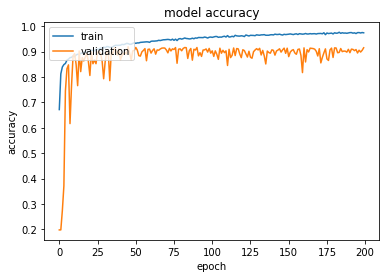

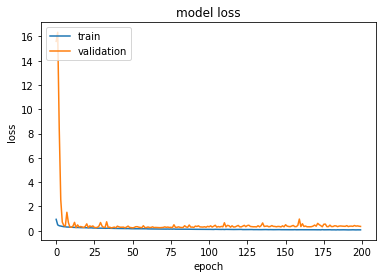

In [39]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

The above plot represents the accurracy and loss incurred by the model. The blue line traces the performance of the train model and the orange line represents the performance of the test set. The first plot shows the change in accuracies as the number of iterations increase whereas the second plot shows the dip in loss as the accuracies change.

These plots have only been generated for the final set. 

The kaggle score is 90.720. The score could have further been improved if other deep learning models were implemented due due to other coursework and submissions, I was able to work on improvising CNN model to its max.

Questions asked:

1. Explanation of Design and implementation of choices of your models - all the models that were considered during the execution of the model have been explained along with the code snippets.

2. Implementation of design choices - All the choices that were made have there codes snippets along with explanation.

3. Kaggle Competition Score - 90.720%

4. Results Analysis:

     a. Runtime performance: 
     Training - 1200 seconds, test prediction - 38.9 seconds.
     b. Comparision of different algorithms and parameters: 
     Different CNN architectures were compared based on the time taken and accuracies of the train and test sets.
     Each of the models have been numbered above. Corresponding to each model, the accuracy has been discussed here.
     1. model1(leaky relu)         - train(0.85), val(0.76), test(0.72)  ~4sec per step
     2. model2(basic with relu)    - train(0.89), val(0.84), test(0.824) ~5sec per step
     3. model3(+CNN Layer)         - train(0.92), val(0.86), test(0.846) ~5sec per step
     4. model4(+CNN Layer)         - train(0.95), val(0.87), test(0.867) ~5sec per step
     5. model5(+Batch Layer)       - train(0.89), val(0.82), test(0.803) ~11sec per step
     6. model6(- extra Batch Layer)- train(0.97), val(0.90), test(0.88)  ~6sec per step
     7. model7(final model)        - train(0.97), val(0.91), test(0.907) ~6sec per step
     
     The hyperparameters in the final model were also altered to conclude this result.
     For choosing optimizer : When it came to optimizers, many optimizers were tested such as SGD, Adagrad, AdaDelta, RMSProp and Adam. Out of these three, only Adam was able to generate best results because it is an improvisation of all the optimizers it captures momentum as well as properties of RMSProp.
     c. Explanation of my model: Stepwise explanation has been done above. Convolution is nothing but weighted sum of pixel values of the image. As we define the size of the sliding window, the convolution calculates the weight over those values under consideration. As the window slides, it convolves the window with the images to generate a new value for the image pixel. Once the values are generated, max pooling is executed. Max pooling is used for reducing the dimensionality of the image. What is does is it picks up the maximum values from the set of values within the window and allocates it as the new value of the reduced dimension. This window keeps on sliding till a new layer with reduced dimensionality is produced. But the layers produced are 3D in nature and for a fully connected network, we need a vector of values. To do that flatten() is used which converts it into a vector. Lastly, Dense layer is a fully connected network just like an ANN. Dropout layers are also added to drop the neurons in the layer i.e. if p=0.5, then 50% of the neurons are dropped. Batch Normalization can also be done. It is another way to regularizer the data.

    Hyerparameter tuning is another part that need to be considered while convolving the layers. These are usually generated by testing and trying different values. For example, what kindly of padding shall be done(same is preserved as it borders the outline with same values as the previous layer), what kind of activation function shall be chosen(linear or relu). I tried with linear and later adding a layer of LeakyRelu layer but that hampered the performance of the model, therefore activation function was directly set to relu. Different combinations with dropout were tested as well but setting it equal to 0.5 yielded best results.

    Also, the activation function is set to relu as it resolves the problem of vanishing gradient. Thats why, when the activation was set to linear, the accuracy was dropped because of vanishing gradient.

    kernel size is set to 3X3 for Conv2D as this the smallest window on which the model performs best convolution. Even the number of filters are chosen to be small so that the model does not overfit the training set. The initial value is small but as the parameters increase, the number of filters change accordingly.

    For max_pooling, the window size is 2X2 so that no information is lost as well as it is made sure that the edges are sharpened. For Dense, a fully connected network is designed, therfore the transition from given nodes to the output nodes shall be smooth and it shall be made sure that no information is lost on the way. Adding too many layers can also lead to overfitting the train data resulting in lower accuracy.

    Usually the CNN initial layers work as edge detector and as we increase the number of layers more features start becoming prominent. Max pooling after CNN makes edges noticeable. Also dense layers help in retaining the properties of the data, therefore more the layers, more hidden features can be fetched.
     d. Plots: the plots for model accuracy and losses have been plotted and explained above with the code.
     e. Code evaluation: The code has been split into 90-10 ratio for comparision. The training data has been tested on various hyperparameters and best results ahve been calculated. The above calculated results are the best results, hence have been add to the report all the others had lower accuracy for all the parameters other than the ones stated. The accuracy obtained for training was maximum for the uncommented network and was equal to 97% on training with test accuracy as 90.72%. For other combinations, training accuracy was 97%and below.